In [1]:
import numpy as np
from scipy.stats import norm
import tensorflow as tf
from tqdm import tqdm

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [4]:
from matplotlib import animation
import seaborn as sns

sns.set(color_codes=True)

In [5]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

# Typical data distribution

In [6]:
class DataDistribution(object):
    def __init__(self, mu=4, sigma=0.5):
        self.mu = mu
        self.sigma = sigma

    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples

In [7]:
sample_size = 10000

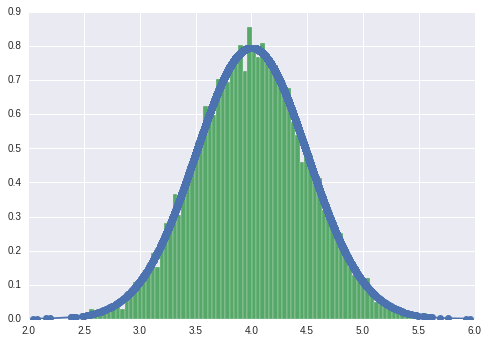

In [8]:
sample = DataDistribution().sample(sample_size)

fit = norm.pdf(sample, np.mean(sample), np.std(sample))

plt.plot(sample, fit,'-o')
plt.hist(sample, normed=True, bins=100)
plt.show()

# Typical noise distribuiton

In [9]:
class GeneratorDistribution(object):
    def __init__(self, d_range=8):
        self.d_range = d_range

    def sample(self, N):
        return np.linspace(-self.d_range, self.d_range, N) + \
            np.random.random(N) * 0.01

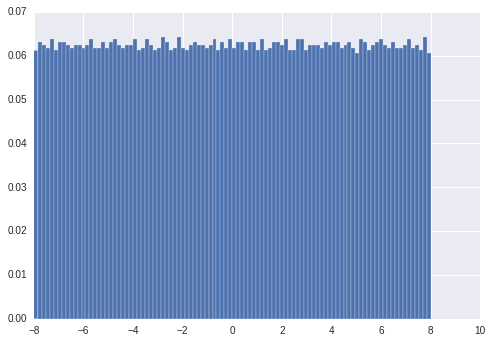

In [10]:
sample = GeneratorDistribution().sample(sample_size)

plt.hist(sample, normed=True, bins=100)
plt.show()

# Linear layer wrapper

In [11]:
def linear(input_vec, out_size, scope=None, stddev=1.0):
    norm = tf.random_normal_initializer(stddev=stddev)
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        weights = tf.get_variable(
            'weights',
            [input_vec.get_shape()[1], out_size],
            initializer=norm)
        bias = tf.get_variable(
            'bias',
            [out_size],
            initializer=const)
        return tf.matmul(input_vec, weights) + bias

# Simple one layer generator

In [12]:
def generator(input_vec, hidden_size):
    h0 = tf.nn.softplus(linear(input_vec, hidden_size, 'g0'))
    h1 = linear(h0, 1, 'g1')
    return h1

# Simple 3 layer discriminator

In [13]:
def discriminator(input_vec, hidden_size, minibatch_layer=True):
    h0 = tf.tanh(linear(input_vec, hidden_size, 'd0'))
    h1 = tf.tanh(linear(h0, hidden_size, 'd1'))

    # without the minibatch layer, the discriminator needs an additional layer
    # to have enough capacity to separate the two distributions correctly
    if minibatch_layer:
        h2 = create_minibatch(h1)
    else:
        h2 = tf.tanh(linear(h1, hidden_size, scope='d2'))

    h3 = tf.sigmoid(linear(h2, 1, scope='d3'))
    return h3

Minibatch func (from https://arxiv.org/abs/1606.03498)

In [14]:
def create_minibatch(input_vec, num_kernels=5, kernel_dim=3):
    x = linear(input_vec, num_kernels * kernel_dim, scope='minibatch', stddev=0.02)
    activation = tf.reshape(x, (-1, num_kernels, kernel_dim))
    diffs = tf.expand_dims(activation, 3) - tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)
    abs_diffs = tf.reduce_sum(tf.abs(diffs), 2)
    minibatch_features = tf.reduce_sum(tf.exp(-abs_diffs), 2)
    return tf.concat(1, [input_vec, minibatch_features])

The method can be loosely summarized as follows:

- Take the output of some intermediate layer of the discriminator.
- Multiply it by a 3D tensor to produce a matrix (of size num_kernels x kernel_dim in the code below).
- Compute the L1-distance between rows in this matrix across all samples in a batch, and then apply a negative exponential.
- The minibatch features for a sample are then the sum of these exponentiated distances.
- Concatenate the original input to the minibatch layer (the output of the previous discriminator layer) with the newly created minibatch features, and pass this as input to the next layer of the discriminator.

# Update step wrapper

In [15]:
def update(loss, var_list,
           initial_learning_rate=0.005, decay=0.95, num_decay_steps=100):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        batch,
        num_decay_steps,
        decay,
        staircase=True
    )

    optimizer = tf.train.GradientDescentOptimizer(learning_rate)

    update_step = optimizer.minimize(
        loss,
        global_step=batch,
        var_list=var_list
    )

    return update_step

# GAN (https://arxiv.org/abs/1406.2661)

In [16]:
class GAN(object):
    def __init__(self, data, gen, batch_size, minibatch, hidden_size):
        self.data = data
        self.gen = gen
        self.batch_size = batch_size
        self.minibatch = minibatch
        self.mlp_hidden_size = hidden_size
        self.anim_frames = []
        self._create_model()

    def _create_model(self):
        
        if self.minibatch:
            learning_rate = 0.005
        else:
            learning_rate = 0.03
        
        # In order to make sure that the discriminator is providing useful gradient
        # information to the generator from the start, we're going to pretrain the
        # discriminator using a maximum likelihood objective. We define the network
        # for this pretraining step scoped as D_pre.
        with tf.variable_scope('D_pre'):
            self.pre_input = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.pre_labels = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            D_pre = discriminator(self.pre_input, self.mlp_hidden_size * 2, self.minibatch)
            self.pre_loss = tf.reduce_mean(tf.square(D_pre - self.pre_labels))
            self.pre_opt = update(self.pre_loss, None, initial_learning_rate=learning_rate)

        # This defines the generator network - it takes samples from a noise
        # distribution as input, and passes them through an MLP.
        with tf.variable_scope('G'):
            self.z = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.G = generator(self.z, self.mlp_hidden_size)

        # The discriminator tries to tell the difference between samples from the
        # true data distribution (self.x) and the generated samples (self.z).
        #
        # Here we create two copies of the discriminator network (that share parameters),
        # as you cannot use the same network with different inputs in TensorFlow.
        with tf.variable_scope('D') as scope:
            self.x = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.D_real = discriminator(self.x, self.mlp_hidden_size * 2, self.minibatch)
            scope.reuse_variables()
            self.D_gen = discriminator(self.G, self.mlp_hidden_size * 2, self.minibatch)

        # Define the loss for discriminator and generator networks (see the original
        # paper for details), and create optimizers for both
        self.loss_d = tf.reduce_mean(-tf.log(self.D_real) - tf.log(1 - self.D_gen))
        # @Todo: very important to do correct generator loss
        self.loss_g = tf.reduce_mean(-tf.log(self.D_gen))
        #self.loss_g = tf.reduce_mean(tf.log(1 - self.D_gen))

        tf_vars = tf.trainable_variables()
        self.d_pre_params = [v for v in tf_vars if v.name.startswith('D_pre/')]
        self.d_params = [v for v in tf_vars if v.name.startswith('D/')]
        self.g_params = [v for v in tf_vars if v.name.startswith('G/')]

        self.opt_d = update(self.loss_d, self.d_params, initial_learning_rate=learning_rate)
        self.opt_g = update(self.loss_g, self.g_params, initial_learning_rate=learning_rate)

    def train(self, session, num_steps, num_pretrain_steps,
              log_interval=100, anim_path=None):
        tf.initialize_all_variables().run()
        
        print("0-epoch")
        plot_distributions(self, session, self.batch_size)

        # pretraining discriminator
        for step in tqdm(range(num_pretrain_steps)):
            d = (np.random.random(self.batch_size) - 0.5) * 10.0
            labels = norm.pdf(d, loc=self.data.mu, scale=self.data.sigma)
            pretrain_loss, _ = session.run([self.pre_loss, self.pre_opt], {
                self.pre_input: np.reshape(d, (self.batch_size, 1)),
                self.pre_labels: np.reshape(labels, (self.batch_size, 1))
            })
        self.weightsD = session.run(self.d_pre_params)

        # copy weights from pre-training over to new D network
        for i, v in enumerate(self.d_params):
            session.run(v.assign(self.weightsD[i]))
            
        print("0-epoch with pretrain")
        plot_distributions(self, session, self.batch_size)
        
        loss_d_history = []
        loss_g_history = []

        for step in tqdm(range(1, num_steps + 1)):
            # update discriminator
            x = self.data.sample(self.batch_size)
            z = self.gen.sample(self.batch_size)
            loss_d, _ = session.run([self.loss_d, self.opt_d], {
                self.x: np.reshape(x, (self.batch_size, 1)),
                self.z: np.reshape(z, (self.batch_size, 1))
            })

            # update generator
            z = self.gen.sample(self.batch_size)
            loss_g, _ = session.run([self.loss_g, self.opt_g], {
                self.z: np.reshape(z, (self.batch_size, 1))
            })
            
            loss_d_history.append(loss_d)
            loss_g_history.append(loss_g)      

            if step % log_interval == 0:
                try:
                    print("{} training epoch".format(step))
                    plot_distributions(self, session, self.batch_size)
                except:
                    print("something go wrong")
#                 print('{}:\t{:.3}\t{:.3}'.format(step, loss_d, loss_g))

            if anim_path:
                self.anim_frames.append(
                    self._samples(session, self.batch_size))
        history = {
            "D_loss": loss_d_history,
            "G_loss": loss_g_history
        }
        
        return history

# Helpers

In [17]:
def plot_unimetric(history, metric):
    plt.figure()
    plt.plot(history[metric])
    plt.title('model {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.show()

In [18]:
def samples(model, session, batch_size, num_points=1000, num_bins=100):
    '''
    Return a tuple (db, pd, pg), where db is the current decision
    boundary, pd is a histogram of samples from the data distribution,
    and pg is a histogram of generated samples.
    '''
    xs = np.linspace(-model.gen.d_range, model.gen.d_range, num_points)
    bins = np.linspace(-model.gen.d_range, model.gen.d_range, num_bins)

    # decision boundary
    db = np.zeros((num_points, 1))
    for i in range(num_points // batch_size):
        db[batch_size * i:batch_size * (i + 1)] = session.run(
            model.D_real, 
            feed_dict = {
                model.x: np.reshape(
                    xs[batch_size * i:batch_size * (i + 1)],
                    (batch_size, 1)
            )
        })

    # data distribution
    d = model.data.sample(num_points)
    pd, _ = np.histogram(d, bins=bins, density=True)

    # generated samples
    zs = np.linspace(-model.gen.d_range, model.gen.d_range, num_points)
    g = np.zeros((num_points, 1))
    for i in range(num_points // batch_size):
        g[batch_size * i:batch_size * (i + 1)] = session.run(
            model.G, 
            feed_dict = {
                model.z: np.reshape(
                    zs[batch_size * i:batch_size * (i + 1)],
                    (batch_size, 1)
            )
        })
    pg, _ = np.histogram(g, bins=bins, density=True)

    return db, pd, pg

In [19]:
def plot_distributions(model, session, batch_size):
    db, pd, pg = samples(model, session, batch_size)
    db_x = np.linspace(-model.gen.d_range, model.gen.d_range, len(db))
    p_x = np.linspace(-model.gen.d_range, model.gen.d_range, len(pd))
    f, ax = plt.subplots(1)
    ax.plot(db_x, db, label='decision boundary')
    ax.set_ylim(0, 1)
    plt.plot(p_x, pd, label='real data')
    plt.plot(p_x, pg, label='generated data')
    plt.title('1D Generative Adversarial Network')
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    plt.legend()
    plt.show()

In [20]:
# def save_animation(model, anim_path):
#     f, ax = plt.subplots(figsize=(6, 4))
#     f.suptitle('1D Generative Adversarial Network', fontsize=15)
#     plt.xlabel('Data values')
#     plt.ylabel('Probability density')
#     ax.set_xlim(-6, 6)
#     ax.set_ylim(0, 1.4)
#     line_db, = ax.plot([], [], label='decision boundary')
#     line_pd, = ax.plot([], [], label='real data')
#     line_pg, = ax.plot([], [], label='generated data')
#     frame_number = ax.text(
#         0.02,
#         0.95,
#         '',
#         horizontalalignment='left',
#         verticalalignment='top',
#         transform=ax.transAxes
#     )
#     ax.legend()

#     db, pd, _ = model.anim_frames[0]
#     db_x = np.linspace(-model.gen.d_range, model.gen.d_range, len(db))
#     p_x = np.linspace(-model.gen.d_range, model.gen.d_range, len(pd))

#     def init():
#         line_db.set_data([], [])
#         line_pd.set_data([], [])
#         line_pg.set_data([], [])
#         frame_number.set_text('')
#         return line_db, line_pd, line_pg, frame_number

#     def animate(i):
#         frame_number.set_text(
#             'Frame: {}/{}'.format(i, len(model.anim_frames))
#         )
#         db, pd, pg = model.anim_frames[i]
#         line_db.set_data(db_x, db)
#         line_pd.set_data(p_x, pd)
#         line_pg.set_data(p_x, pg)
#         return (line_db, line_pd, line_pg, frame_number)

#     anim = animation.FuncAnimation(
#         f,
#         animate,
#         init_func=init,
#         frames=len(model.anim_frames),
#         blit=True
#     )
#     anim.save(anim_path, fps=30, extra_args=['-vcodec', 'libx264'])

# Simple test 1: no minibatch

In [21]:
minibatch = False
hidden_size = 4
batch_size = 20
num_steps = 1000
num_pretrain_steps = 1000
log_interval = 200
anim = None

0-epoch


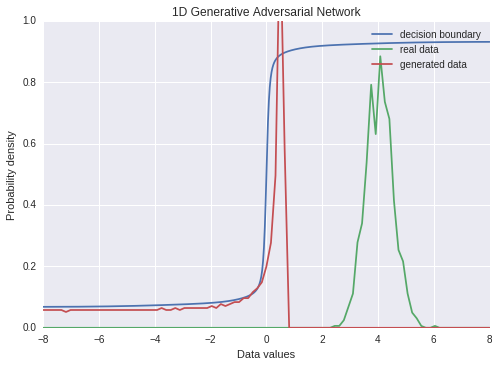

100%|██████████| 1000/1000 [00:00<00:00, 1327.52it/s]


0-epoch with pretrain


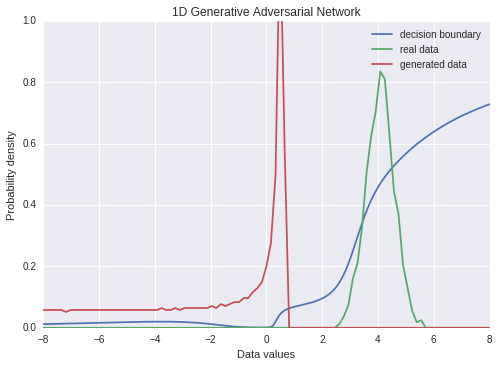

 14%|█▎        | 136/1000 [00:00<00:01, 612.99it/s]

200 training epoch


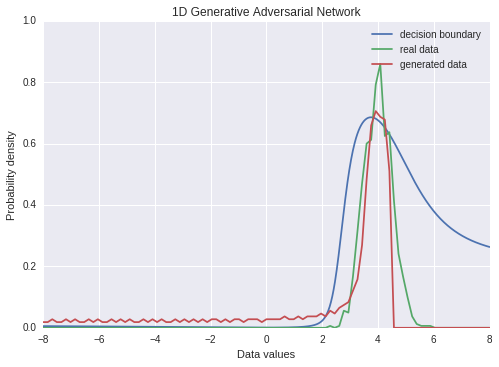

 36%|███▌      | 359/1000 [00:00<00:01, 490.70it/s]

400 training epoch


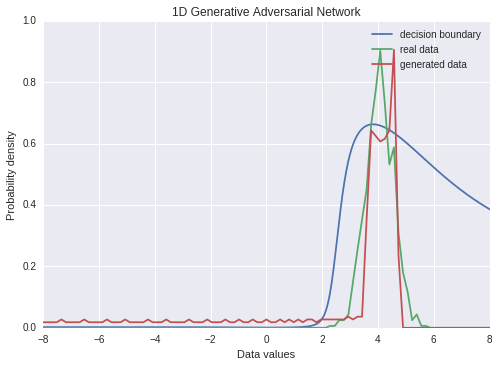

 57%|█████▊    | 575/1000 [00:01<00:01, 419.71it/s]

600 training epoch


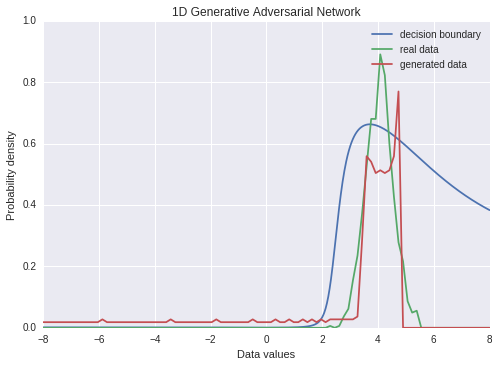

 72%|███████▏  | 719/1000 [00:01<00:00, 342.00it/s]

800 training epoch


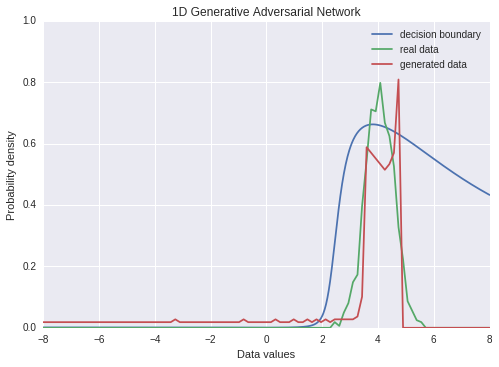

 96%|█████████▌| 959/1000 [00:02<00:00, 408.83it/s]

1000 training epoch


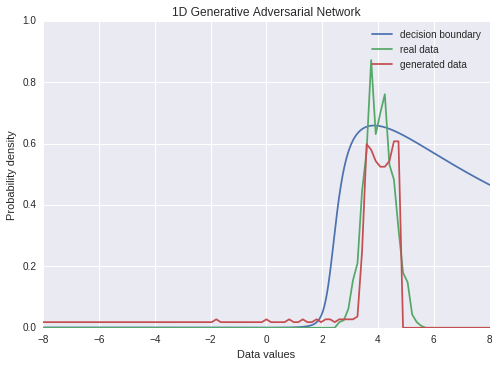

100%|██████████| 1000/1000 [00:02<00:00, 351.98it/s]


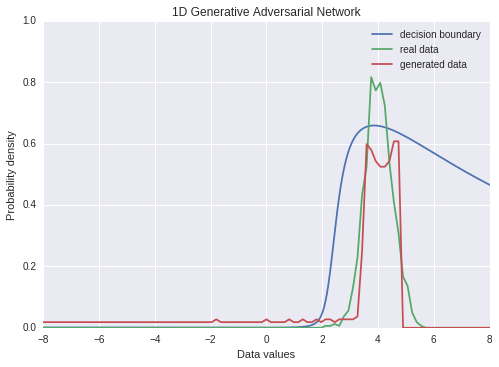

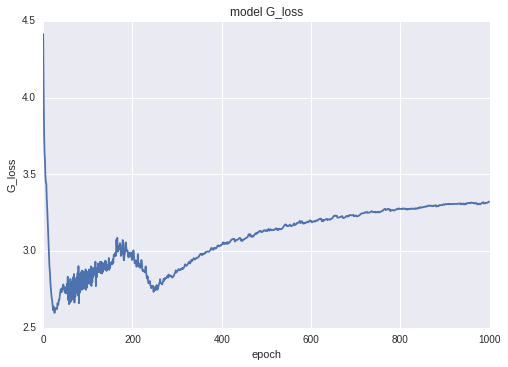

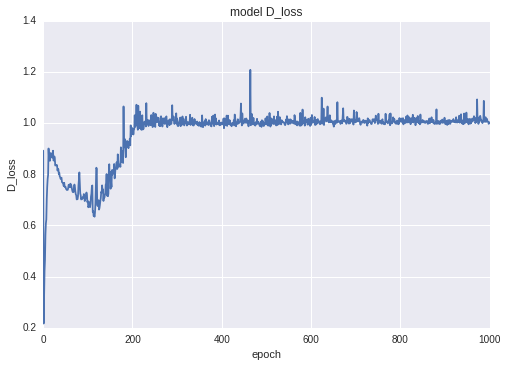

In [22]:
tf.reset_default_graph()
with tf.Session() as session:
    np.random.seed(seed)
    tf.set_random_seed(seed)
    model = GAN(
        DataDistribution(),
        GeneratorDistribution(d_range=8),
        batch_size,
        minibatch,
        hidden_size
    )
    history = model.train(
        session,
        num_steps, num_pretrain_steps,
        log_interval, anim)
    try:
        plot_distributions(model, session, batch_size)
    except:
        pass
    for metric in history:
        plot_unimetric(history, metric)
    
tf.reset_default_graph()

# Simple test 2: with minibatch technique

In [23]:
minibatch = True
hidden_size = 8
batch_size = 20
num_steps = 1000
num_pretrain_steps = 1000
log_interval = 200
anim = None

0-epoch


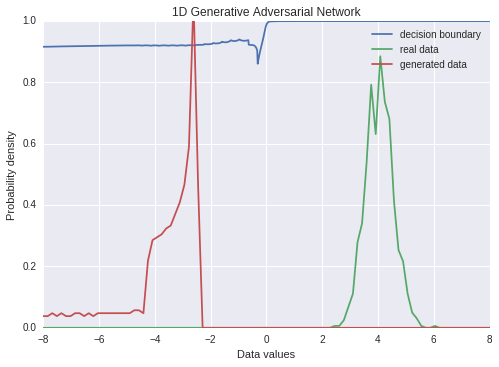

100%|██████████| 1000/1000 [00:01<00:00, 604.97it/s]


0-epoch with pretrain


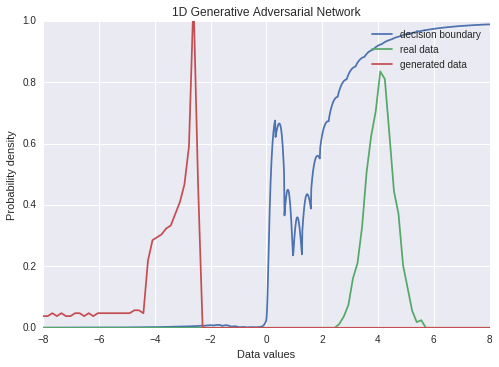

 19%|█▉        | 188/1000 [00:00<00:02, 272.80it/s]

200 training epoch


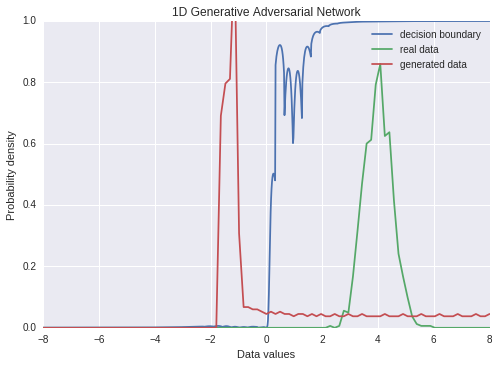

 39%|███▉      | 392/1000 [00:01<00:02, 240.27it/s]

400 training epoch


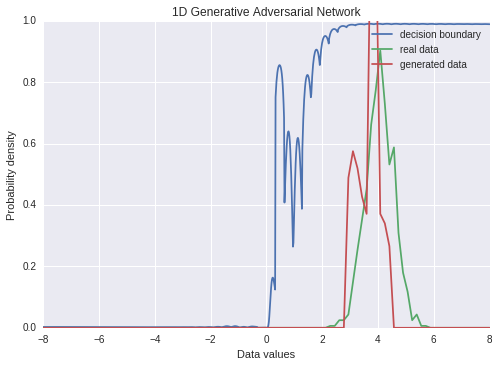

 58%|█████▊    | 583/1000 [00:02<00:01, 246.37it/s]

600 training epoch


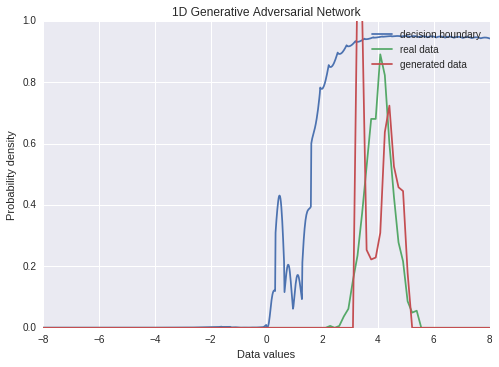

 79%|███████▉  | 792/1000 [00:03<00:00, 259.41it/s]

800 training epoch


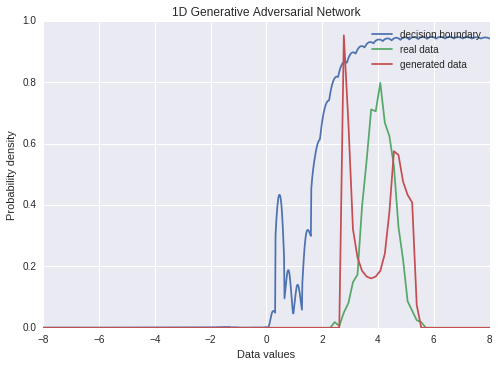

100%|█████████▉| 999/1000 [00:04<00:00, 259.45it/s]

1000 training epoch


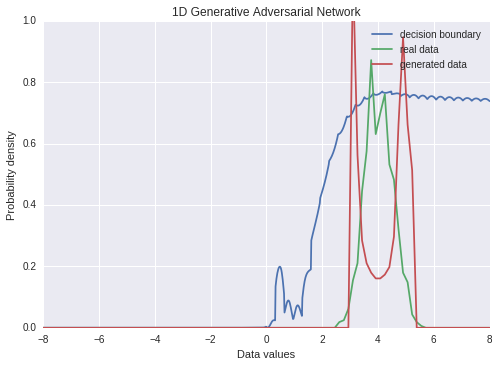

100%|██████████| 1000/1000 [00:05<00:00, 192.02it/s]


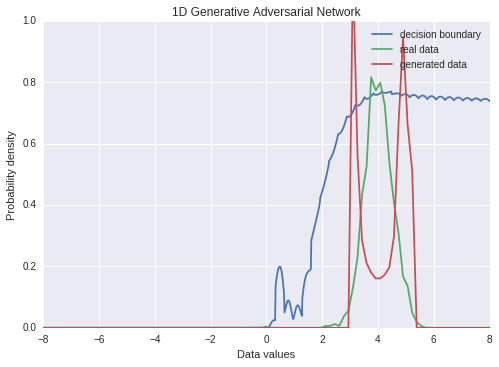

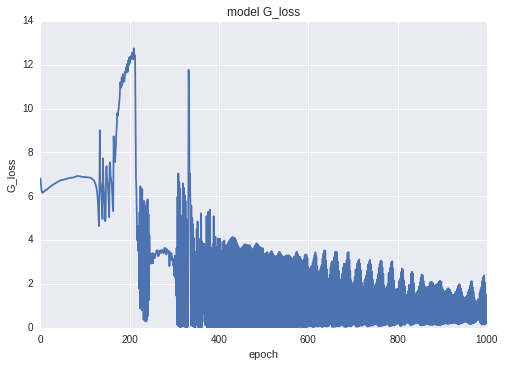

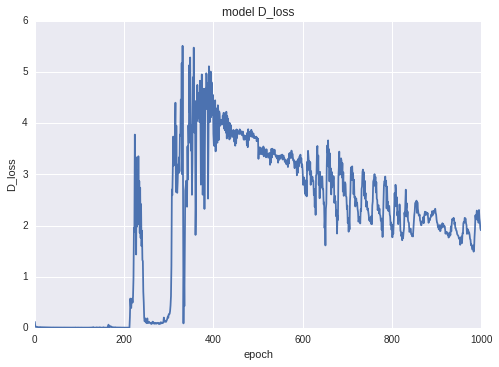

In [24]:
tf.reset_default_graph()
with tf.Session() as session:
    np.random.seed(seed)
    tf.set_random_seed(seed)
    model = GAN(
        DataDistribution(),
        GeneratorDistribution(d_range=8),
        batch_size,
        minibatch,
        hidden_size
    )
    history = model.train(
        session,
        num_steps, num_pretrain_steps,
        log_interval, anim)
    try:
        plot_distributions(model, session, batch_size)
    except:
        pass
    for metric in history:
        plot_unimetric(history, metric)
    
tf.reset_default_graph()

# Let's create more complex 'real' data

In [25]:
class ComplexDataDistribution(object):
    def __init__(self, mu=1.5, sigma=0.5, mu2=-3.0, sigma2=1.0):
        self.mu = mu
        self.sigma = sigma
        self.mu2 = mu2
        self.sigma2 = sigma2

    def sample(self, N):
#         N1 = np.random.randint(N)
        N1 = N//2
        N2 = N - N1
        samples = np.append(
            np.random.normal(self.mu, self.sigma, N1),
            np.random.normal(self.mu2, self.sigma2, N2))
        samples.sort()
        return samples

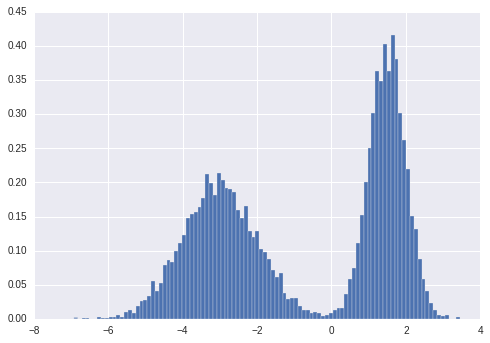

In [26]:
np.random.seed(seed)
sample = ComplexDataDistribution().sample(sample_size)

plt.hist(sample, normed=True, bins=100)
plt.show()

# 'Complex' test 1: no minibatch

In [27]:
minibatch = False
hidden_size = 4
batch_size = 20
num_steps = 1000
num_pretrain_steps = 1000
log_interval = 200
anim = None

0-epoch


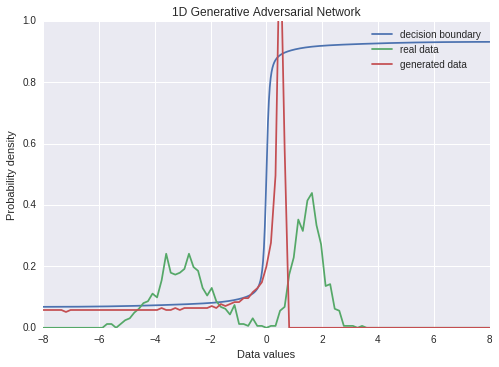

100%|██████████| 1000/1000 [00:00<00:00, 1322.02it/s]


0-epoch with pretrain


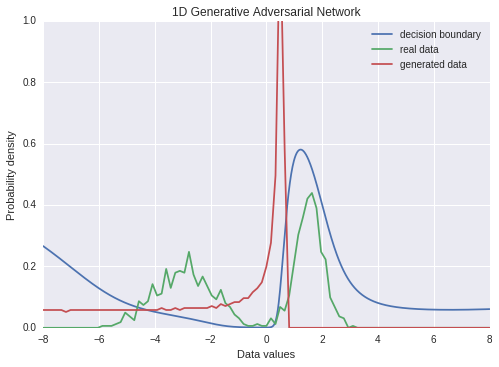

 14%|█▍        | 139/1000 [00:00<00:01, 632.39it/s]

200 training epoch


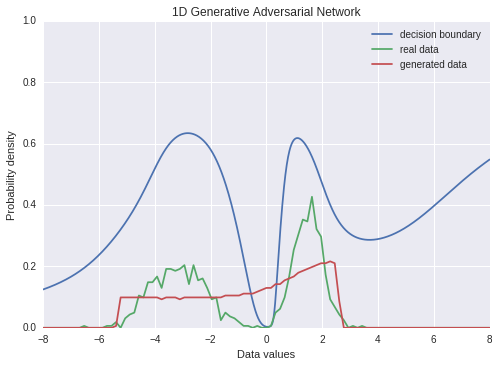

 34%|███▍      | 344/1000 [00:00<00:01, 443.30it/s]

400 training epoch


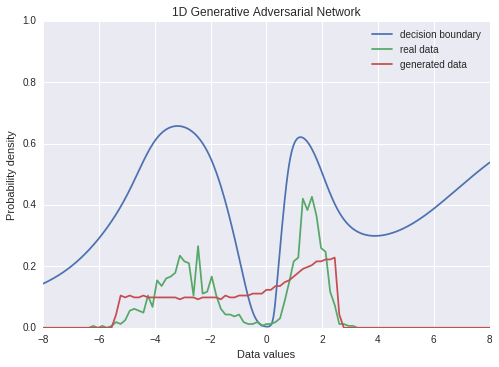

 55%|█████▌    | 553/1000 [00:01<00:01, 397.62it/s]

600 training epoch


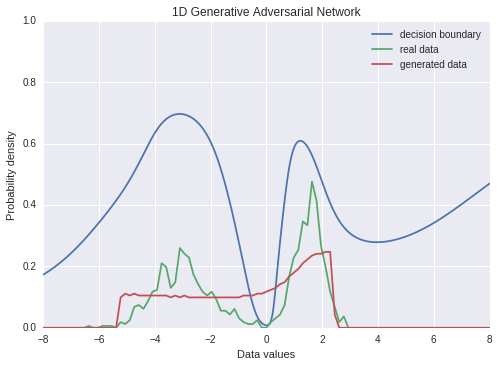

 77%|███████▋  | 767/1000 [00:02<00:00, 392.08it/s]

800 training epoch


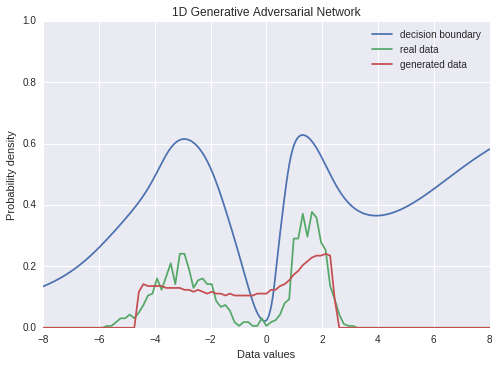

 98%|█████████▊| 985/1000 [00:02<00:00, 398.03it/s]

1000 training epoch


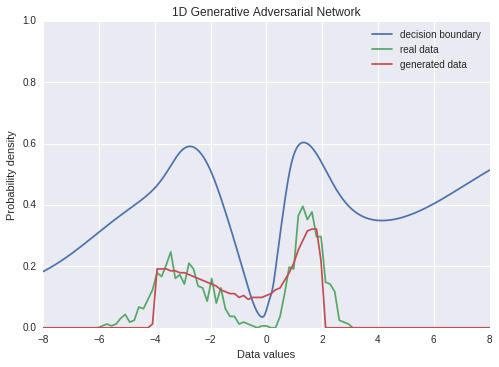

100%|██████████| 1000/1000 [00:03<00:00, 332.08it/s]


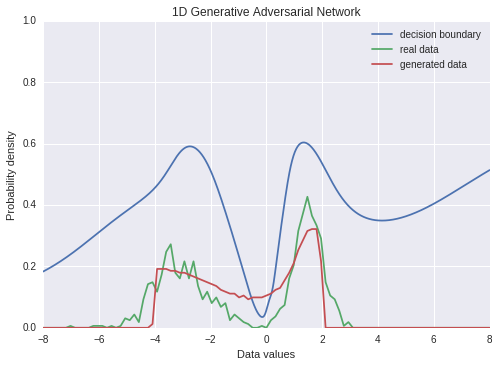

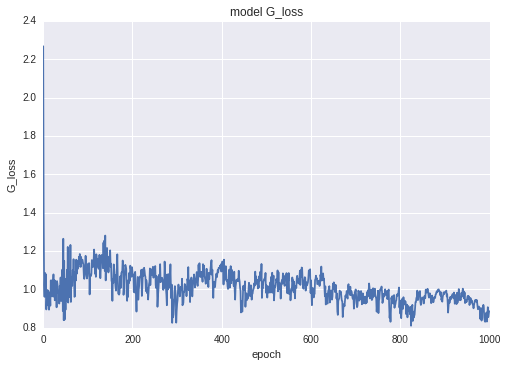

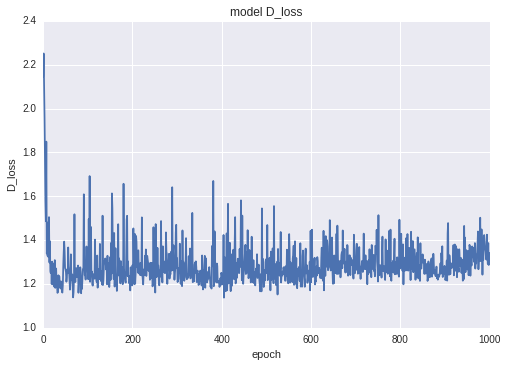

In [28]:
tf.reset_default_graph()
with tf.Session() as session:
    np.random.seed(seed)
    tf.set_random_seed(seed)
    model = GAN(
        ComplexDataDistribution(),
        GeneratorDistribution(d_range=8),
        batch_size,
        minibatch,
        hidden_size
    )
    history = model.train(
        session,
        num_steps, num_pretrain_steps,
        log_interval, anim)
    try:
        plot_distributions(model, session, batch_size)
    except:
        pass
    for metric in history:
        plot_unimetric(history, metric)
    
tf.reset_default_graph()

# 'Complex' test 2: with minibatch technique

In [29]:
minibatch = True
hidden_size = 4
batch_size = 20
num_steps = 1000
num_pretrain_steps = 1000
log_interval = 200
anim = None

0-epoch


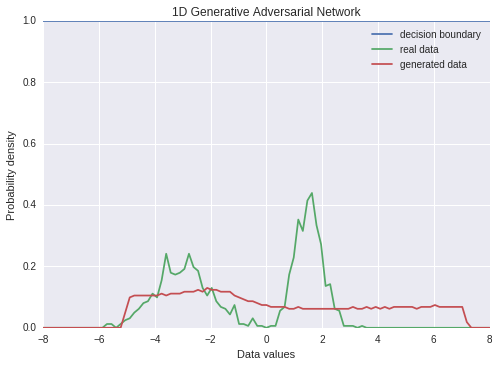

100%|██████████| 1000/1000 [00:01<00:00, 523.56it/s]


0-epoch with pretrain


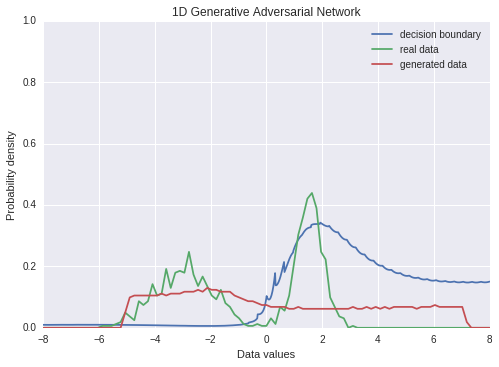

 17%|█▋        | 169/1000 [00:00<00:03, 271.78it/s]

200 training epoch


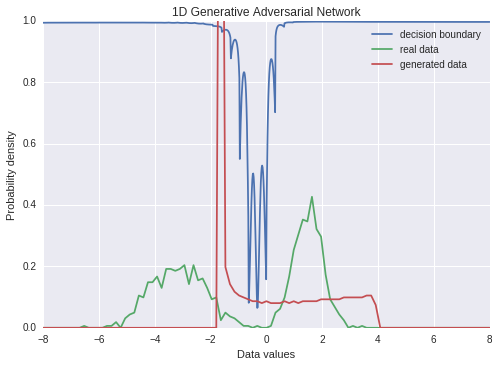

 38%|███▊      | 383/1000 [00:01<00:02, 269.83it/s]

400 training epoch


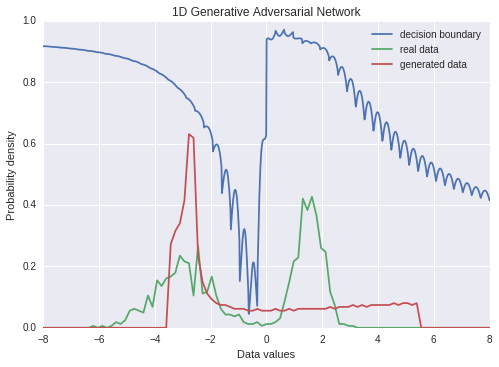

 60%|█████▉    | 597/1000 [00:02<00:01, 267.58it/s]

600 training epoch


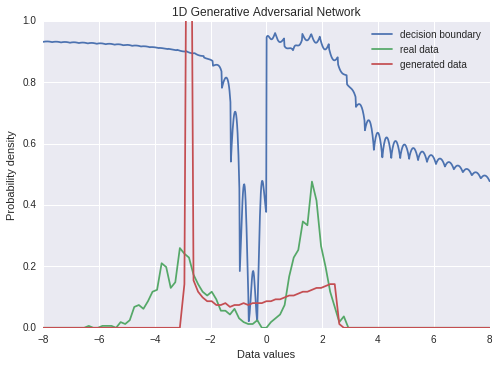

 78%|███████▊  | 778/1000 [00:03<00:00, 251.93it/s]

800 training epoch


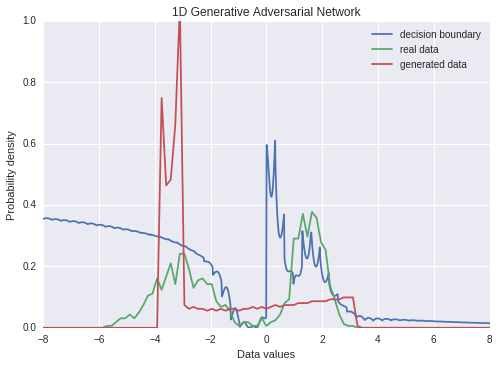

 98%|█████████▊| 981/1000 [00:05<00:00, 182.98it/s]

1000 training epoch


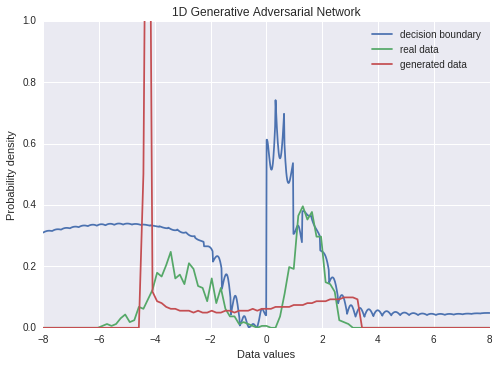

100%|██████████| 1000/1000 [00:05<00:00, 184.97it/s]


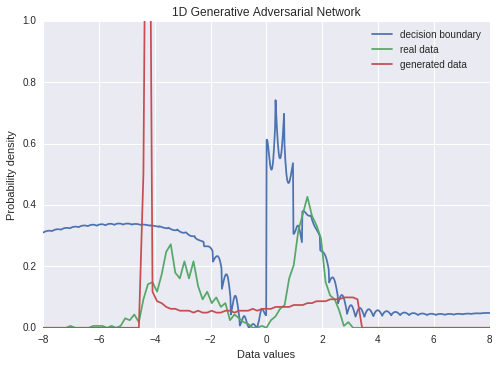

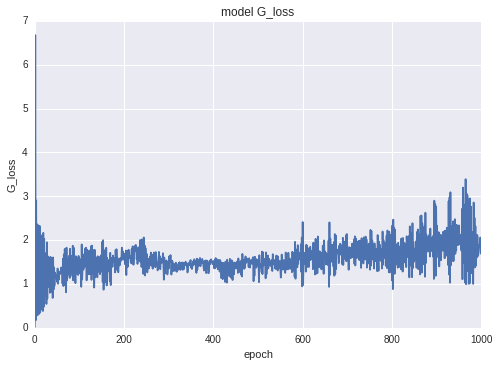

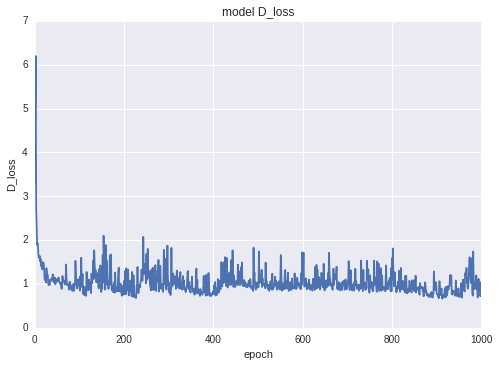

In [30]:
tf.reset_default_graph()
with tf.Session() as session:
    np.random.seed(seed)
    tf.set_random_seed(seed)
    model = GAN(
        ComplexDataDistribution(),
        GeneratorDistribution(d_range=8),
        batch_size,
        minibatch,
        hidden_size
    )
    history = model.train(
        session,
        num_steps, num_pretrain_steps,
        log_interval, anim)
    try:
        plot_distributions(model, session, batch_size)
    except:
        pass
    for metric in history:
        plot_unimetric(history, metric)
    
tf.reset_default_graph()